# Test I2-free spectra

In [24]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

sys.path.append('/home/paul/pyodine/')  # Put in the pyodine path on your machine here!

import pyodine

_c = 299792458.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import utilities_song as utilities

Pars = utilities.pyodine_parameters.Parameters()

In [3]:
res_file = '/home/paul/data_song2/data_res/sigdra_obs/s1_2015-05-03T04-13-35_ext/s1_2015-05-03T04-13-35_ext_res1.h5'

In [4]:
# Restore the RUN 1 fit results for the observation
chunks, fit_results = pyodine.fitters.results_io.restore_results_object(utilities, res_file)

Loading template from file: /home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5
Order correction: -1

Barycentric redshift between template and observation: 
v = 1068.1439999999998, z = 3.5629448690133486e-06

Total number of created chunks: 528 (in result file: 528)
Number of created chunks per order: 22


In [8]:
redchi2 = np.array([r.redchi for r in fit_results])

In [16]:
# Smooth the LSFs
smooth_dict = {
    'smooth_pixels': 160,
    'smooth_orders': 3,
    'order_separation': 15
}

lsf_smoothed = pyodine.lib.misc.smooth_lsf(
    chunks, smooth_dict['smooth_pixels'], smooth_dict['smooth_orders'], 
    smooth_dict['order_separation'], fit_results,
    redchi2=redchi2, osample=Pars.osample_obs)

LSFarr = pyodine.models.lsf.LSF_Array(lsf_smoothed, np.array([ch.order for ch in chunks]),
                                      np.array([ch.abspix[0] for ch in chunks]))

In [17]:
# Build the model and fitter
lsf_model = pyodine.models.lsf.model_index['FixedLSF']
wave_model = pyodine.models.wave.LinearWaveModel
cont_model = pyodine.models.cont.LinearContinuumModel
model = pyodine.models.spectrum.SimpleModel(
    lsf_model, wave_model, cont_model, fit_results[0].model.iodine_atlas, 
    stellar_template=fit_results[0].model.stellar_template, lsf_array=LSFarr,
    osample_factor=fit_results[0].model.osample_factor, conv_width=fit_results[0].model.conv_width)

fitter = pyodine.fitters.lmfit_wrapper.LmfitWrapper(model)

In [28]:
# Now build the I2-free spectrum, following the receipe described in Diaz +2019
lsfs = []
spectrum_models = []
spectrum_models2 = []
chunk_waves = []
waves_fine = []
chunk_conts = []

temps_conv_fine = []
temps_conv = []
I2_intensities = []
I2_free_specs = []

#I2_free_specs2 = []
I2s_conv = []
I2s_fine = []

for i, res in enumerate(fit_results):
    # Load the chunk
    chunk = chunks[i]
    # Load the parameters
    lsf_params = res.params.filter(prefix='lsf')
    wave_params = res.params.filter(prefix='wave')
    cont_params = res.params.filter(prefix='cont')
    
    # Generate the "observed" wavelength grid, to be returned in the end
    wave_obs = res.model.wave_model.eval(chunk.pix, wave_params)
    chunk_waves.append(wave_obs)
    # Evaluate the continuum model
    cont_obs = res.model.cont_model.eval(chunk.pix, cont_params)
    chunk_conts.append(cont_obs)
    
    # Generate the model spectrum and LSF model
    # If the smoothed LSF array is used, build a new spectrum model with the smoothed LSF
    if lsf_model.name() == 'FixedLSF':
        params2 = res.params
        lsf_params2 = {'order': chunk.order, 'pixel0': chunk.abspix[0], 'amplitude': 1.}
        # Exchange the LSF parameters from the fit result object for the smoothed LSF parameters
        for key in params2.filter(prefix='lsf').keys():
            del params2['lsf_' + key]
        for key in lsf_params2.keys():
            params2['lsf_' + key] = lsf_params2[key]
        # Build the spectrum model
        spectrum_model_flux = model.eval(chunk, params2, require=None, chunk_ind=i)
        spectrum_model = pyodine.components.Spectrum(spectrum_model_flux, wave_obs, cont_obs)
        
        #lsf = model.lsf_model.eval(model.lsf_array, lsf_params2)
        x_lsf, lsf = model.eval_lsf(params2)
        lsfs.append(lsf)
        spectrum_models.append(spectrum_model)
    
    # Else simply use the spectrum model from the fit result object
    else:
        #spectrum_model = res.fitted_spectrum
        # Build the spectrum model
        spectrum_model_flux = model.eval(chunk, res.params, require='full', chunk_ind=i)
        spectrum_model = pyodine.components.Spectrum(spectrum_model_flux, wave_obs, cont_obs)
        
        spectrum_models.append(spectrum_model)
        
        #x_lsf = res.model.lsf_model.generate_x(osample, Pars.lsf_conv_width)
        #lsf = res.model.lsf_model.eval(x_lsf, lsf_params)
        x_lsf, lsf = res.model.eval_lsf(lsf_params)
        lsfs.append(lsf)

    # Generate the "fine" wavelength grid, used for convolution.
    # Extends beyond the chunk limits as defined by chunk.padding.
    pix_fine = pyodine.lib.misc.osample(chunk.padded.pix, res.model.osample_factor)
    wave_fine = res.model.wave_model.eval(pix_fine, wave_params)
    
    # Calculate relativistic doppler factor
    beta = res.params['velocity'] / _c
    doppler = np.sqrt((1. + beta) / (1. - beta))
    
    # Get the correct template chunk
    wave_tem = res.model.stellar_template[i].wave
    flux_tem = res.model.stellar_template[i].flux
    # Ensure "normalization" to mean value 1.0
    flux_tem = flux_tem / np.mean(flux_tem)
    # Scale depth of stellar template
    flux_tem = res.params['tem_depth'] * (flux_tem - 1.0) + 1.0
    
    # Interpolate shifted stellar template to the fine grid
    tck = splrep(wave_tem * doppler, flux_tem, s=0)
    tem_fine = splev(wave_fine, tck, der=0)
    
    # Load iodine atlas
    iod_ch = res.model.iodine_atlas.get_wavelength_range(
        wave_fine[0], wave_fine[-1], require=None)
    # Ensure "normalization" to mean value 1.0
    flux_iod = iod_ch.flux / np.mean(iod_ch.flux)
    # Scale depth of iodine atlas
    flux_iod = res.params['iod_depth'] * (flux_iod - 1.0) + 1.0
    
    # Interpolate iodine atlas to the fine grid
    tck = splrep(iod_ch.wave, flux_iod, s=0)
    iod_fine = splev(wave_fine, tck, der=0)
    I2s_fine.append(iod_fine)
    waves_fine.append(wave_fine)
    
    # Construct the template convolved with LSF (Equ. 6 in Diaz +2019)
    # Convolve with LSF
    tem_conv_fine = np.convolve(tem_fine, lsf, 'same')
    temps_conv_fine.append(tem_conv_fine)
    # Resample back to original grid, given by wavelength
    tem_conv = pyodine.lib.misc.rebin(wave_fine, tem_conv_fine, wave_obs)
    # Apply continuum
    #tem_conv *= cont_obs
    
    # Add first products to lists
    temps_conv.append(tem_conv)
    
    # Now subtract the convolved template from the model to obtain the I2 intensity (Equ. 7 in Diaz +2019)
    # (model needs to be divided by the continuum to make this work, or template multiplied by it)
    I2_intensity = spectrum_model.flux / cont_obs - tem_conv #* cont_obs
    
    # Add this to list also
    I2_intensities.append(I2_intensity)
    
    # Finally, obtain the I2-free spectrum by subtracting the I2 intensity from the observation
    # (Equ. 9 in Diaz +2019)
    # (again divide the observation by the continuum to make this work, unless the I2 intensity already includes it)
    I2_free_spec = chunk.flux / cont_obs - I2_intensity
    
    # Add it to list
    I2_free_specs.append(I2_free_spec)
    
    """ Tested it - it actually results in exactly the same, as it should. 
    # ALTERNATIVE:
    # The same algorithm can be understood as the residuals between model and observation
    # summed with the convolved template (also Equ. 9 in Diaz +2019)
    I2_free_spec2 = (chunk.flux - spectrum_model.flux) / cont_obs + tem_conv #* cont_obs
    
    # Add it to list
    I2_free_specs2.append(I2_free_spec2)
    """
    
    # For completeness also compute the convolved I2
    I2_conv_fine = np.convolve(iod_fine, lsf, 'same')
    # Resample back to original grid, given by wavelength
    I2_conv = pyodine.lib.misc.rebin(wave_fine, I2_conv_fine, wave_obs)
    # Apply continuum
    #I2_conv *= cont_obs
    
    # Add to list
    I2s_conv.append(I2_conv)
    
    spectrum_model2 = np.convolve(iod_fine * tem_fine, lsf, 'same')
    spectrum_model2 = cont_obs * pyodine.lib.misc.rebin(wave_fine, spectrum_model2, wave_obs)
    spectrum_models2.append(pyodine.components.Spectrum(spectrum_model2, wave_obs, cont_obs))

<ParameterSet (values: 17)>
    cont_intercept  =  22468.377067404886
    cont_slope      =  -8.811626625219454
    iod_depth       =  0.9841743829425532
    lsf_left_1      =  9.37369804849396
    lsf_left_2      =  -9.10113171831359
    lsf_left_3      =  4.281868988439984
    lsf_left_4      =  -1.2988699728100765
    lsf_left_5      =  0.3154175387489869
    lsf_right1      =  8.543951959705144
    lsf_right2      =  -9.403511468847407
    lsf_right3      =  4.374586030865652
    lsf_right4      =  -1.2115560510506485
    lsf_right5      =  0.26789198008960774
    tem_depth       =  0.9979976731522335
    velocity        =  1019.8868000117868
    wave_intercept  =  5190.011718002675
    wave_slope      =  0.02166344717103523


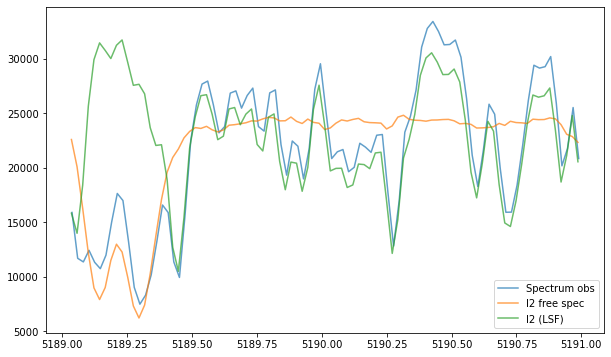

In [41]:
plot_chunk = 100

obs_ch = chunks[plot_chunk]

print(fit_results[plot_chunk].params)

fig = plt.figure(figsize=(10,6))

#plt.plot(chunk_waves[plot_chunk], fit_results[plot_chunk].fitted_spectrum.flux, alpha=0.7, label='Spectrum model')
#plt.plot(chunk_waves[plot_chunk], spectrum_models[plot_chunk].flux, 
#         alpha=0.7, label='Spectrum model 2')
#plt.plot(chunk_waves[plot_chunk], spectrum_models2[plot_chunk].flux, 
#         alpha=0.7, label='Spectrum model 3')
plt.plot(obs_ch.wave, obs_ch.flux, alpha=0.7, label='Spectrum obs')

plt.plot(chunk_waves[plot_chunk], I2_free_specs[plot_chunk]*chunk_conts[plot_chunk], 
         alpha=0.7, label='I2 free spec')
#plt.plot(chunk_waves[plot_chunk], temps_conv[plot_chunk]/np.mean(temps_conv[plot_chunk])*chunk_conts[plot_chunk], 
#         alpha=0.7, label='Template (LSF)')
plt.plot(chunk_waves[plot_chunk], I2s_conv[plot_chunk]*chunk_conts[plot_chunk], 
         alpha=0.7, label='I2 (LSF)')
#plt.plot(chunk_waves[plot_chunk], I2_intensities[plot_chunk]+1., 
#         alpha=0.7, label='I2 intensity')
plt.legend()

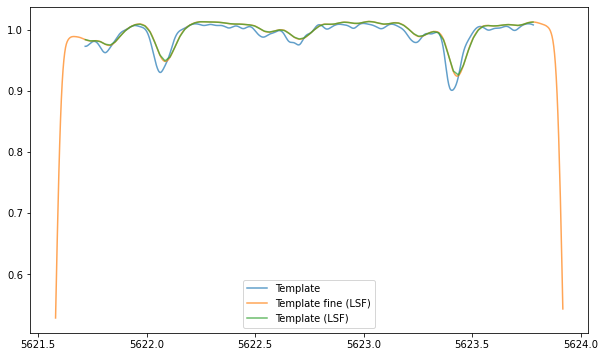

In [32]:
# Template comparison (and I2)
plot_chunk = 300

temp_spec = fit_results[0].model.stellar_template.get_wavelength_range(
    chunk_waves[plot_chunk][0], chunk_waves[plot_chunk][-1])
I2_spec = fit_results[0].model.iodine_atlas.get_wavelength_range(
    chunk_waves[plot_chunk][0], chunk_waves[plot_chunk][-1])

fig = plt.figure(figsize=(10,6))

plt.plot(temp_spec.wave, temp_spec.flux,#*fit_result[plot_chunk].model.cont_model.eval(np.arange(len(temp_spec.flux)), fit_result[plot_chunk].params.filter(prefix='cont')), 
         alpha=0.7, label='Template')
plt.plot(waves_fine[plot_chunk], temps_conv_fine[plot_chunk],#*chunk_conts[plot_chunk], 
         alpha=0.7, label='Template fine (LSF)')
plt.plot(chunk_waves[plot_chunk], temps_conv[plot_chunk],#*chunk_conts[plot_chunk], 
         alpha=0.7, label='Template (LSF)')

#plt.plot(I2_spec.wave, I2_spec.flux,#*fit_result[plot_chunk].model.cont_model.eval(np.arange(len(I2_spec.flux)), fit_result[plot_chunk].params.filter(prefix='cont')), 
#         alpha=0.7, label='I2')
#plt.plot(chunk_waves[plot_chunk], (I2s_conv[plot_chunk]-1.0)/fit_result[plot_chunk].params['iod_depth'] + 1.0,#*chunk_conts[plot_chunk], 
#         alpha=0.7, label='I2 (LSF)')
plt.legend()

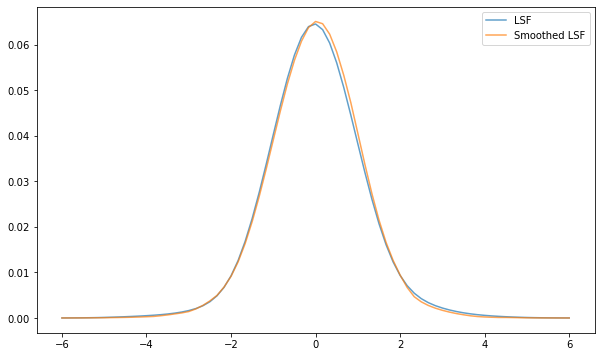

In [34]:
x_lsf, lsf = fit_results[plot_chunk].model.eval_lsf(fit_results[plot_chunk].params)

fig = plt.figure(figsize=(10,6))

plt.plot(x_lsf, lsf, alpha=0.7, label='LSF')
plt.plot(x_lsf, lsfs[plot_chunk], alpha=0.7, label='Smoothed LSF')
plt.legend()